In [28]:
from utils.onmf import Online_NMF, update_code_within_radius
import itertools
import numpy as np
from PIL import Image
from skimage.transform import downscale_local_mean
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from tensorly import unfold as tl_unfold
from tqdm import trange
from time import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [55]:
class Image_Reconstructor():
    def __init__(self,
                 path,
                 n_components=100,
                 iterations=200,
                 sub_iterations=20,
                 num_patches=1000,
                 batch_size=20,
                 downscale_factor=2,
                 patch_size=7,
                 patches_file='',
                 patches = None,
                 is_matrix=False,
                 is_stack=False,
                 is_color=True):
        '''
        batch_size = number of patches used for training dictionaries per ONMF iteration
        sources: array of filenames to make patches out of
        patches_array_filename: numpy array file which contains already read-in images
        '''
        self.path = path
        self.n_components = n_components
        self.iterations = iterations
        self.sub_iterations = sub_iterations
        self.num_patches = num_patches
        self.batch_size = batch_size
        self.downscale_factor = downscale_factor
        self.patch_size = patch_size
        self.patches = patches
        self.patches_file = patches_file
        self.is_matrix = is_matrix
        self.is_stack = is_stack  # if True, input data is a 3d array
        self.is_color = is_color
        self.W = np.zeros(shape=(patch_size**2, n_components))
        if is_color:
            #self.W = np.ones(shape=(3*patch_size**2, n_components))
            self.W = np.random.rand(3*patch_size**2, n_components)
        self.code = np.ones(shape=(n_components, iterations*batch_size))
        self.A_recons = []

        '''
        # read in patches
        if patches_file:
            self.patches = np.load(patches_file)
        elif not is_stack:
            self.patches = self.read_patches(patch_size=patch_size, iterations=iterations,
                                             batch_size=batch_size, is_matrix=is_matrix)
            print(self.patches.shape)
        else:
            self.patches = self.read_patches_stack(patch_size=patch_size, iterations=iterations,
                                                   batch_size=batch_size)
            b = np.asarray(self.patches)
            b = np.moveaxis(b, 0, -1)
            self.patches = b
            print(self.patches.shape)
        '''
        # read in image as array
        self.data = self.read_img_as_array(path=self.path, is_matrix=self.is_matrix, is_color=self.is_color)

    def read_img_as_array(self, path, is_matrix=False, is_color=True):
        '''
        Read input image as a narray
        '''

        if is_matrix:
            img = np.load(path)
            data = (img + 1) / 2  # it was +-1 matrix; now it is 0-1 matrix
        else:
            img = Image.open(path)
            if is_color:
                img = img.convert('RGB')
                #  = data.reshape(-1, data.shape[1])  # (row, col, 3) --> (3row, col)
            else:
                img = img.convert('L')
            data = np.asarray(img) / 255
            print('img.shape', data.shape)
            # normalize pixel values (range 0-1)
        print('data.shape', data.shape)
        return data

    def read_patches(self, patch_size=7, iterations=500, batch_size=20, is_matrix=False):
        '''
        reads in patches from images specified by self.sources
        '''
        patches = []
        for filename in self.sources:
            print("reading {}".format(filename))
            img_patches = self.image_to_patches(filename, iterations=iterations, batch_size=batch_size,
                                                patch_size=patch_size, is_matrix=is_matrix)
            patches = patches + img_patches.T.tolist()
        return np.array(patches).T

    def read_patches_stack(self, patch_size=7, iterations=500, batch_size=20):
        '''
        reads in patches from stack of matrices specified by self.sources
        '''
        stack_patches = []
        for filename in self.sources:
            print("reading {}".format(filename))
            stack_patches = self.stack_to_patches(filename, patch_size=patch_size, iterations=iterations,
                                                  batch_size=batch_size)
        return np.array(stack_patches)

    def image_to_patches(self, path, patch_size=7, iterations=500, batch_size=20, color=False, downscale_factor=2,
                         is_matrix=False, is_recons=False):
        '''
        #*****

        args:
            path (string): Path and filename of input image
            patch_size (int): Pixel dimension of square patches taken of image
            color (boolean): Specifies conversion of image to RGB (True) or grayscale (False).
                Default value = false. When color = True, images in gray colorspace will still appear
                gray, but will thereafter be represented in RGB colorspace using three channels.
            downscale_factor: Specifies the extent to which the image will be downscaled. Greater values
                will result in more downscaling but faster speed. For no downscaling, use downscale_factor=1.
        returns: #***

        '''
        #open image and convert it to either RGB (three channel) or grayscale (one channel)
        if is_matrix:
            img = np.load(path)
            data = (img + 1) / 2  # it was +-1 matrix; now it is 0-1 matrix
        else:
            img = Image.open(path)
            if color:
                img = img.convert('RGB')
                img = tl_unfold(img, mode=2).T
                print('img.shape_color_after_unfolding', img.shape)
            else:
                img = img.convert('L')
            # normalize pixel values (range 0-1)
            data = np.asarray(img) / 255

        '''
        img = np.load(path)
        data = (img + 1) / 2  # it was +-1 matrix; now it is 0-1 matrix
        '''
        if DEBUG:
            print(np.asarray(img))

        # downscale image for speed
        if downscale_factor > 1:
            data = downscale_local_mean(data, (downscale_factor, downscale_factor))

        # show_array(data)
        if not is_recons:
            patches = extract_patches_2d(data, (patch_size, patch_size), max_patches=iterations*batch_size)
        else:  # for reconstruction we need to use all patches not to mess up with the ordering
            patches = extract_patches_2d(data, (patch_size, patch_size))
        # we do not need more than iterations*batch_size patches for training dictionaries
        # convert 7x7 squares to 1d (49,) vectors
        patches_flat = patches.reshape(len(patches), -1).T
        # (Num patches)*(7*7) array
        # .reshape(len(patches),-1) makes it two dimensional -- (Num patches)*(whatever that's correct)
        # take transpose to make it 49 * (Num patches)
        print(patches_flat.shape)
        return patches_flat

    def extract_random_patches(self):
        '''
        Extract 'num_patches' many random patches of given size
        color -- 3 patch_size * patch_size (color pixels are flattened)
        b/w -- patch_size * patch_size
        '''
        x = self.data.shape
        k = self.patch_size

        if self.is_color:
            X = np.zeros(shape=(3*(k ** 2), 1))
            for i in np.arange(self.num_patches):
                a = np.random.choice(x[0] - k)  # y coordinate of the top left corner of the random patch
                b = np.random.choice(x[1] - k)  # x coordinate of the top left corner of the random patch
                Y = self.data[a:a+k, b:b+k, :]
                Y = Y.reshape((-1, 1))  # size 3k**2 by 1
                # print('Y.shape', Y.shape)
                if i == 0:
                    X = Y
                else:
                    X = np.append(X, Y, axis=1)  # x is class ndarray
        else:  # b/w image
            X = np.zeros(shape=(k ** 2, 1, 1))
            for i in np.arange(self.num_patches):
                a = np.random.choice(x[0] - k)  # x coordinate of the top left corner of the random patch
                b = np.random.choice(x[1] - k)  # y coordinate of the top left corner of the random patch
                Y = self.data[a:a + k, b:b + k]
                Y = Y.reshape(k ** 2, 1)  # size k**2 by 1
                # print('Y.shape', Y.shape)
                if i == 0:
                    X = Y
                else:
                    X = np.append(X, Y, axis=1)  # X is class ndarray
        return X  # X.shape = (3k**2, num_patches) for color, (k**2, 1) for b/w

    def stack_to_patches(self, path, patch_size=7, iterations=500, batch_size=20, downscale_factor=2):
        # converts a stack of data matrices into 3d array of patch matrices
        X = np.load(path)
        data = (X + 1) / 2
        m = X.shape[0]  # number of matrices stacked up
        stack_patches_flat = []
        for i in np.arange(0, m):
            img = data[i, :, :]
            # downscale image for speed
            if downscale_factor > 1:
                img = downscale_local_mean(img, (downscale_factor, downscale_factor))

            # show_array(data)
            patches = extract_patches_2d(img, (patch_size, patch_size), max_patches=iterations * batch_size)
            # we do not need more than iterations*batch_size patches for training dictionaries
            patches_flat = patches.reshape(len(patches), -1).T  # -1 means unspecified
            stack_patches_flat.append(patches_flat)

        #  b = np.asarray(stack_patches_flat)
        #  np.moveaxis(b, 0, -1)
        #  stack_patches_flat = np.stack((stack_patches_flat, patches_flat), axis=0)
        return stack_patches_flat

    def save_patches(self, filename):
        '''
        Save patches array to filename. in future set patches_file in constructor
        '''
        np.save(filename, self.patches)

    def display_dictionary(self, W):
        k = self.patch_size
        
        rows = np.round(np.sqrt(W.shape[1]))
        rows = rows.astype(int)
        if rows ** 2 == W.shape[1]:
            cols = rows
        else:
            cols = rows + 1
        
        fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(6,6),
                                subplot_kw={'xticks':[], 'yticks': []})
        
        for ax, i in zip(axs.flat, range(rows*cols)):
            if not self.is_color:
                ax.imshow(W.T[i].reshape(k, k), cmap="gray", interpolation='nearest')
            else:
                patch = W.T[i].reshape(k, k, 3)
                ax.imshow(patch/np.max(patch))

        plt.tight_layout()
        plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
        plt.show()
            

    def get_downscaled_dims(self, path, downscale_factor=None, is_matrix=False):
        # need to put is_matrix arg at the end to avoid error (don't know why)
        if downscale_factor is None:
            downscale_factor = self.downscale_factor

        if not is_matrix:
            img = Image.open(path)
            img = np.asarray(img.convert('L'))
        else:
            img = np.load(path)

        data = downscale_local_mean(img, (downscale_factor, downscale_factor))
        return data.shape[0], data.shape[1]

    def train_dict(self, is_stack=False):
        print('training dictionaries from patches...')
        '''
        Trains dictionary based on patches.
        '''
        W = self.W
        At = []
        Bt = []
        code = self.code
        for t in trange(self.iterations):
            X = self.extract_random_patches()
            if t == 0:
                onmf = Online_NMF(X,
                                  n_components=self.n_components,
                                  iterations=self.sub_iterations,
                                  batch_size=self.batch_size,
                                  ini_dict=None,
                                  history=0,
                                  alpha=None)
                W, A, B, C, H = onmf.train_dict()
               
            else:
                onmf = Online_NMF(X,
                                  n_components=self.n_components,
                                  iterations=self.sub_iterations,
                                  batch_size=self.batch_size,
                                  ini_dict=W,
                                  ini_A = A, 
                                  ini_B = B, 
                                  ini_C = C, 
                                  beta=1,
                                  history=onmf.history,
                                  alpha=None)
                W, A, B, C, H = onmf.train_dict()
            
        self.W = W
        print('dict_shape:', self.W.shape)
        print('code_shape:', self.code.shape)

    def show_array(self, arr):
        plt.figure()
        plt.imshow(arr, cmap="gray")
        plt.show()

    def reconstruct_image(self, path, downscale_factor=None, patch_size=10, is_matrix=False):
        print('reconstructing given image...')
        if downscale_factor is None:
            downscale_factor = self.downscale_factor

        t0 = time()
        dims = self.get_downscaled_dims(path, downscale_factor, is_matrix=is_matrix)
        patches = self.image_to_patches(path, patch_size=patch_size, downscale_factor=downscale_factor,
                                        is_matrix=is_matrix, is_recons=True)
        self.nmf = Online_NMF(patches, self.n_components, self.iterations, self.batch_size)
        code = self.nmf.sparse_code(patches, self.W)
        print('Reconstructed in %.2f seconds' % (time() - t0))
        patches_recons = np.dot(self.W, code).T
        patches_recons = patches_recons.reshape(patches_recons.shape[0], patch_size, patch_size)
        img_recons = reconstruct_from_patches_2d(patches_recons, (dims[0], dims[1]))
        self.show_array(img_recons)
        return code

    def reconstruct_image_color(self, path, recons_resolution=1):
        print('reconstructing given network...')
        '''
        Note: For WAN data, the algorithm reconstructs the normalized WAN matrix A/np.max(A).
        Scale the reconstructed matrix B by np.max(A) and compare with the original network.
        '''
        A = self.read_img_as_array(path)  # A.shape = (row, col, 3)
        A_matrix = A.reshape(-1, A.shape[1])  # (row, col, 3) --> (3row, col)
        [m, n] = A_matrix.shape
        A_recons = np.zeros(shape=A.shape)
        A_overlap_count = np.zeros(shape=(A.shape[0], A.shape[1]))
        k = self.patch_size
        t0 = time()
        c = 0
        num_rows = np.floor((A_recons.shape[0]-k)/recons_resolution).astype(int)
        num_cols = np.floor((A_recons.shape[1]-k)/recons_resolution).astype(int)

        for i in trange(0, A_recons.shape[0]-k, recons_resolution):
            for j in np.arange(0, A_recons.shape[1]-k, recons_resolution):
                patch = A[i:i + k, j:j + k, :] # k by k by 3
                patch = patch.reshape((-1, 1))  # make the patch as a column vector
                # print('patch.shape', patch.shape)
                # coder = SparseCoder(dictionary=self.W.T, transform_n_nonzero_coefs=None,
                #                    transform_alpha=1, transform_algorithm='lasso_lars', positive_code=True)
                # alpha = L1 regularization parameter. alpha=2 makes all codes zero (why?)
                # code = coder.transform(patch.T)
                code = update_code_within_radius(patch, self.W, H0=None, r=None, alpha=1, sub_iter=10, stopping_diff=0.01)
                patch_recons = np.dot(self.W, code).T
                patch_recons = patch_recons.reshape(k, k, 3)

                # now paint the reconstruction canvas
                for x in itertools.product(np.arange(k), repeat=2):
                    c = A_overlap_count[i+x[0], j+x[1]]
                    A_recons[i+x[0], j+x[1], :] = (c*A_recons[i+x[0], j+x[1], :] + patch_recons[x[0], x[1], :])/(c+1)
                    A_overlap_count[i+x[0], j+x[1]] += 1

                # progress status
                #print('reconstructing (%i, %i)th patch out of (%i, %i)' % (i/recons_resolution, j/recons_resolution, num_rows, num_cols))
        print('Reconstructed in %.2f seconds' % (time() - t0))
        print('A_recons.shape', A_recons.shape)
        np.save('Img_dictionary/img_recons_color', A_recons)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6),
                                subplot_kw={'xticks':[], 'yticks': []})
        ax.imshow(A_recons)
        plt.suptitle('Reconstructed image')
        plt.savefig('Img_dictionary/img_recons_color1.jpg', bbox_inches='tight')
        self.A_recons = A_recons
        return A_recons
    
    
def display_recons_dict_list(W_list, 
                                 training_iter_list,
                                 A_recons_list,
                                 save_path,
                                 title=None,
                                 grid_shape=None,
                                 fig_size=[10,10]):
        W = W_list[0]
        n_components = W.shape[1]
        print('W.shape', W.shape)
        k = int(np.sqrt(W.shape[0]/3))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        idx = np.arange(W.shape[1])

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        outer_grid = gridspec.GridSpec(nrows=2, ncols=len(W_list)+1, wspace=0.2, hspace=0.2)
        for t in np.arange(3):
            # make nested gridspecs

            if t == 1: # dictionary
                for j in np.arange(len(W_list)):
                    W = W_list[j]
                    ### Make gridspec
                    inner_grid = outer_grid[t, j+1].subgridspec(rows, cols, wspace=0.2, hspace=0.02)
                    #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                    for i in range(rows * cols):
                        a = i // cols
                        b = i % cols
                        ax = fig.add_subplot(inner_grid[a, b])
                        patch = W.T[idx[i]].reshape(k, k, 3)
                        ax.imshow(patch/np.max(patch), interpolation='nearest')
                        #ax.set_xlabel('Training iter = %i' % training_iter_list[j], fontsize=13)  # get the largest first
                        # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                        ax.set_xticks([])
                        ax.set_yticks([])
                        
            if t == 0: # reconstruction
                for j in np.arange(len(W_list)):
                    A_recons = A_recons_list[j]

                    inner_grid = outer_grid[t, j+1].subgridspec(1, 1, wspace=0, hspace=0)
                    ax = fig.add_subplot(inner_grid[0, 0])
                    ax.imshow(A_recons)
                    
            if t == 2: # original
                a = 1
                for j in np.arange(len(W_list), len(W_list)+2):
                    A = A_recons_list[j]
                    inner_grid = outer_grid[a, 0].subgridspec(1, 1, wspace=0, hspace=0)
                    ax = fig.add_subplot(inner_grid[0, 0])
                    ax.imshow(A)
                    a -= 1
                
        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')
        
def display_recons_dict_list(W_list, 
                                 training_iter_list,
                                 A_recons_list,
                                 save_path,
                                 title=None,
                                 grid_shape=None,
                                 fig_size=[10,10]):
        W = W_list[0]
        n_components = W.shape[1]
        print('W.shape', W.shape)
        k = int(np.sqrt(W.shape[0]/3))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        idx = np.arange(W.shape[1])

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        outer_grid = gridspec.GridSpec(nrows=2, ncols=len(W_list)+1, wspace=0.2, hspace=0.2)
        for t in np.arange(3):
            # make nested gridspecs

            if t == 0: # dictionary
                for j in np.arange(len(W_list)):
                    W = W_list[j]
                    ### Make gridspec
                    inner_grid = outer_grid[t, j+1].subgridspec(rows, cols, wspace=0.2, hspace=0.02)
                    #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                    for i in range(rows * cols):
                        a = i // cols
                        b = i % cols
                        ax = fig.add_subplot(inner_grid[a, b])
                        patch = W.T[idx[i]].reshape(k, k, 3)
                        ax.imshow(patch/np.max(patch), interpolation='nearest')
                        #ax.set_xlabel('Training iter = %i' % training_iter_list[j], fontsize=13)  # get the largest first
                        # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                        ax.set_xticks([])
                        ax.set_yticks([])
                        
            if t == 1: # reconstruction
                for j in np.arange(len(W_list)):
                    A_recons = A_recons_list[j]

                    inner_grid = outer_grid[t, j+1].subgridspec(1, 1, wspace=0, hspace=0)
                    ax = fig.add_subplot(inner_grid[0, 0])
                    ax.imshow(A_recons)
                    
            if t == 2: # original
                a = 0
                for j in np.arange(len(W_list), len(W_list)+2):
                    A = A_recons_list[j]
                    inner_grid = outer_grid[a, 0].subgridspec(1, 1, wspace=0, hspace=0)
                    ax = fig.add_subplot(inner_grid[0, 0])
                    ax.imshow(A)
                    a += 1
                
        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')
        
        
def main():
    patch_size = 10
    #sources = ["Data/renoir/" + str(n) + ".jpg" for n in np.arange(0,1)]
    path_dict_img = "Data/piccaso/1.jpg"
    path_recons = "Data/renoir/0.jpg"
    training_iter_list = [0,2,1000]
    W_list = []
    A_recons_list = []
    for training_iter in training_iter_list:
        reconstructor = Image_Reconstructor(path=path_dict_img,
                                            n_components=25,
                                            iterations=training_iter,
                                            sub_iterations=10,
                                            patch_size=patch_size,
                                            batch_size=10,
                                            num_patches=10,
                                            downscale_factor=10,
                                            is_matrix=False,
                                            is_color=True)
        # reconstructor.save_patches("escher_patches.npy")
        reconstructor.train_dict()
        # reconstructor.W = np.load('Img_dictionary/dict_learned_21.npy')
        W_list.append(reconstructor.W)  # trained dictionary
        #reconstructor.display_dictionary(img_dict)
        reconstructor.reconstruct_image_color(path=path_recons,
                                              recons_resolution=10)
        A_recons_list.append(reconstructor.A_recons)

    ### Append original images for dictionary learning and reconstruction 
    img_dict = reconstructor.read_img_as_array(path_dict_img, is_matrix=False, is_color=True)
    img_recons = reconstructor.read_img_as_array(path_recons, is_matrix=False, is_color=True)
    A_recons_list.append(img_dict)
    A_recons_list.append(img_recons)
        

if __name__ == '__main__':
    #main()
    print('!')

!


In [57]:
patch_size = 20
#sources = ["Data/renoir/" + str(n) + ".jpg" for n in np.arange(0,1)]
path_dict_img = "Data/open_access_imgs/0.jpg"
path_recons = "Data/open_access_imgs/1.jpg"
training_iter_list = [0,100]
W_list = []
A_recons_list = []
for training_iter in training_iter_list:
    reconstructor = Image_Reconstructor(path=path_dict_img,
                                        n_components=25,
                                        iterations=training_iter,
                                        sub_iterations=10,
                                        patch_size=patch_size,
                                        batch_size=10,
                                        num_patches=10,
                                        downscale_factor=10,
                                        is_matrix=False,
                                        is_color=True)
    # reconstructor.save_patches("escher_patches.npy")
    reconstructor.train_dict()
    # reconstructor.W = np.load('Img_dictionary/dict_learned_21.npy')
    W_list.append(reconstructor.W)  # trained dictionary
    #reconstructor.display_dictionary(img_dict)
    reconstructor.reconstruct_image_color(path=path_recons,
                                          recons_resolution=1)
    A_recons_list.append(reconstructor.A_recons)
    
### Append original images for dictionary learning and reconstruction 
img_dict = reconstructor.read_img_as_array(path_dict_img, is_matrix=False, is_color=True)
img_recons = reconstructor.read_img_as_array(path_recons, is_matrix=False, is_color=True)
A_recons_list.append(img_dict)
A_recons_list.append(img_recons)
results_list = [W_list, A_recons_list]
path = "Img_dictionary/results_list.npy"
np.save(path, results_list)

img.shape (1107, 678, 3)
data.shape (1107, 678, 3)
training dictionaries from patches...


0it [00:00, ?it/s]


dict_shape: (1200, 25)
code_shape: (25, 0)
reconstructing given network...
img.shape (1024, 826, 3)
data.shape (1024, 826, 3)


 38%|███████████████▎                        | 385/1004 [18:27<29:41,  2.88s/it]


KeyboardInterrupt: 

In [ ]:
display_recons_dict_list(W_list=W_list, 
                         training_iter_list=training_iter_list,
                         A_recons_list=A_recons_list,
                         fig_size = [9,6.5],
                         save_path = 'Img_dictionary/dict_recons_list_0',
                         title=None)

In [58]:
path = "Data/Open_access_imgs/0.jpg"

In [59]:
img = Image.open(path)
img = img.convert('RGB')

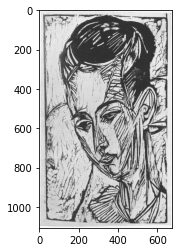

In [60]:
plt.imshow(img)
plt.

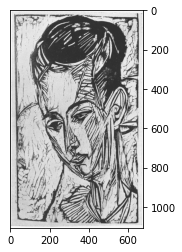

In [67]:
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(img)
plt.show()
f.savefig("Data/Open_access_imgs/2.jpg")